<a href="https://colab.research.google.com/github/Josh-Warren11/RandomNotes/blob/main/Day11_Notes_f21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 11 Notes: Random Forests

Using a new dataset, this set of notes walks through how to use Random Forests in sklearn, and also demonstrates tuning different parameters related to Random Forests. 

In [2]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
data= pd.read_csv('/content/drive/MyDrive/CS167/datasets/breast-cancer-wisconsin-data.csv')
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
# Notice that the 'Unnamed: 32' column is full of NaN... we need to get rid of it. 
data.drop('Unnamed: 32', inplace=True, axis=1)
data.isna().any()

id                         False
diagnosis                  False
radius_mean                False
texture_mean               False
perimeter_mean             False
area_mean                  False
smoothness_mean            False
compactness_mean           False
concavity_mean             False
concave points_mean        False
symmetry_mean              False
fractal_dimension_mean     False
radius_se                  False
texture_se                 False
perimeter_se               False
area_se                    False
smoothness_se              False
compactness_se             False
concavity_se               False
concave points_se          False
symmetry_se                False
fractal_dimension_se       False
radius_worst               False
texture_worst              False
perimeter_worst            False
area_worst                 False
smoothness_worst           False
compactness_worst          False
concavity_worst            False
concave points_worst       False
symmetry_w

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

target = "diagnosis"
predictors = data.columns.drop(target) #gets all of the columns except the target

train_data, test_data, train_sln, test_sln = train_test_split(data[predictors], data[target], test_size = 0.2, random_state=41)

In [5]:
from sklearn import tree
from sklearn import metrics

# Let's use a single tree for comparison
# a default Decision Tree Classifier

dt = tree.DecisionTreeClassifier()
dt.fit(train_data,train_sln)
predictions = dt.predict(test_data)

print("accuracy score: ", metrics.accuracy_score(test_sln,predictions))
vals = data[target].unique() ## possible classification values (M = malignant; B = benign)
conf_mat = metrics.confusion_matrix(test_sln, predictions, labels=vals)
print(pd.DataFrame(conf_mat, index = "True " + vals, columns = "Predicted " + vals))

accuracy score:  0.9385964912280702
        Predicted M  Predicted B
True M           38            2
True B            5           69


In [6]:
# a Random Forest Classifier
forest = RandomForestClassifier(random_state = 0, n_estimators=100)
forest.fit(train_data,train_sln)
predictions = forest.predict(test_data)
print("accuracy score: ", metrics.accuracy_score(test_sln,predictions))

vals = data[target].unique() ## possible classification values (M = malignant; B = benign)
conf_mat = metrics.confusion_matrix(test_sln, predictions, labels=vals)
print(pd.DataFrame(conf_mat, index = "True " + vals, columns = "Predicted " + vals))

accuracy score:  0.9824561403508771
        Predicted M  Predicted B
True M           40            0
True B            2           72


## Feature Importances
Becuase we are building so many small decision trees in a random forest, we have the added benefit of being able to see what features are most commonly used as high information gain features. The code below shows how we can plot the 'Feature Importance' chart for a random forest. 

In this particular run, it looks like perimeter_worst was the most important feature, but there were a handful of others that were important as well. 

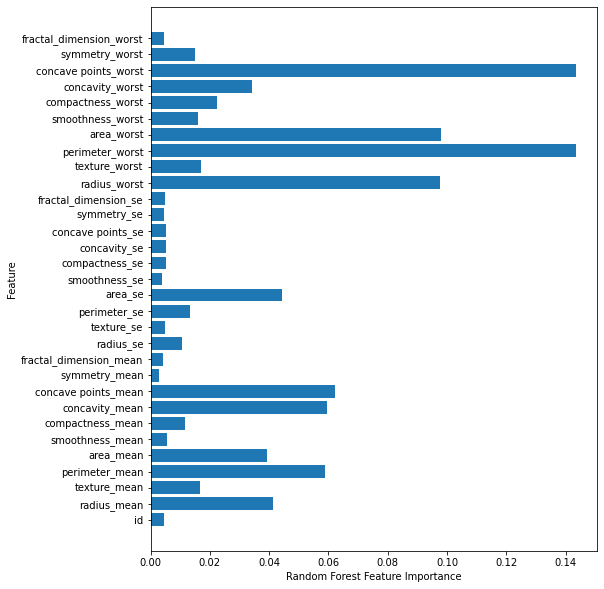

In [7]:
# It looks like our random forest model achieved pretty good accuracy. 
# Now lets check how important each of the features was in the ensemble of models we built.

import matplotlib.pyplot as plt
%matplotlib inline

index = range(len(predictors)) #creates a list of numbers the right size to use as the index

plt.figure(figsize=(8,10)) #making the table a bit bigger so the text is readable
plt.barh(index,forest.feature_importances_,height=0.8) #horizontal bar chart
plt.ylabel('Feature')
plt.yticks(index,predictors) #put the feature names at the y tick marks
plt.xlabel("Random Forest Feature Importance")
plt.show()


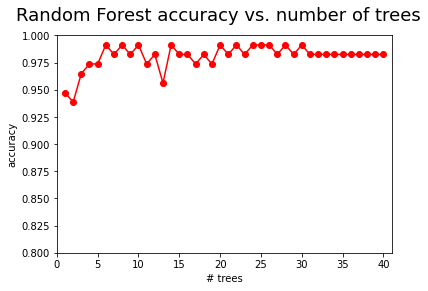

In [10]:
#This function just loops through a series of n_estimator values, builds a different model
#for each, and then plots their respective accuracies. By making it a function, it's easier
#to try out different ranges of numbers
import matplotlib.pyplot as plt

def tune_number_of_trees(n_estimator_values):
    rf_accuracies = []

    for n in n_estimator_values:

        curr_rf = RandomForestClassifier(n_estimators=n, random_state=41)
        curr_rf.fit(train_data,train_sln)
        curr_predictions = curr_rf.predict(test_data)
        curr_accuracy = metrics.accuracy_score(test_sln,curr_predictions)
        rf_accuracies.append(curr_accuracy)


    plt.suptitle('Random Forest accuracy vs. number of trees',fontsize=18)
    plt.xlabel('# trees')
    plt.ylabel('accuracy')
    plt.plot(n_estimator_values,rf_accuracies,'ro-')
    plt.axis([0,n_estimator_values[-1]+1,.8,1])

    plt.show()
    
tune_number_of_trees(range(1,41))



It looks like whether we are using small numbers of trees or large ones, the accuracy stays about the same. It appears at least sometimes that Random Forest doesn't take a lot of tuning of the number of trees.

Now let's try tuning the number of features used with each tree.

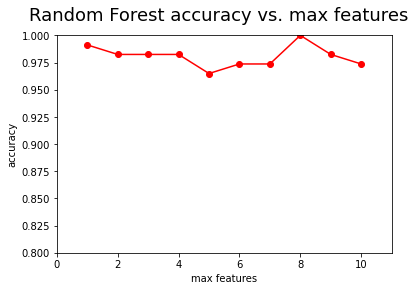

In [11]:
def tune_max_features(max_features_values):
    rf_accuracies = []

    for m in max_features_values:

        curr_rf = RandomForestClassifier(n_estimators=10,max_features=m, random_state=31)
        curr_rf.fit(train_data,train_sln)
        curr_predictions = curr_rf.predict(test_data)
        curr_accuracy = metrics.accuracy_score(test_sln,curr_predictions)
        rf_accuracies.append(curr_accuracy)


    plt.suptitle('Random Forest accuracy vs. max features',fontsize=18)
    plt.xlabel('max features')
    plt.ylabel('accuracy')
    plt.plot(max_features_values,rf_accuracies,'ro-')
    plt.axis([0,max_features_values[-1]+1,.8,1])

    plt.show()
    
tune_max_features(range(1,11))

Note that the above could be subject to changes based on the initial random_state.

For this data, which is apparently very easy to learn on (accuracy is very hight), the number of features used with each tree also didn't matter much when used with an ensemble of 10 trees. This is probably something worth tuning if you have a lot of features, especially if many of them might not be very relevant.

# Exercise #1

In [12]:
data= pd.read_csv('/content/drive/MyDrive/CS167/datasets/winequality-white.csv')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [13]:
target= 'quality'
predictors = data.columns.drop(target)
train_data, test_data, train_sln, test_sln = train_test_split(data[predictors], data[target], test_size = 0.2, random_state=41)

In [16]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor()
forest.fit(train_data,train_sln)
predictions = forest.predict(test_data)
print("accuracy score: ", metrics.r2_score(test_sln,predictions))


accuracy score:  0.528155844155844
